In [203]:
import cvxpy as cp
import numpy as np

In [689]:
from collections import defaultdict
N = 25
K = 3
ALL_ITEMS = np.arange(N)
def update(action, item_selected, posterior_parameters, epoch_picks):
    if item_selected == N:
        n_is = [
            int(ix in action) for ix in range(N)
        ]
        v_is = [epoch_picks[i] for i in range(N)]
        posterior_parameters = [
            (a + n_is[ix], b + v_is[ix])
            for ix, (a, b) in enumerate(posterior_parameters)
        ]
        epoch_picks = defaultdict(int)
        epoch_ended = True
    else:
        epoch_picks[item_selected] += 1
        epoch_ended = False
    return posterior_parameters, epoch_picks, epoch_ended

def propose():
    return np.random.choice(
        np.arange(N, dtype=int),
        size=K,
        replace=False,
    )

def step(action, preferences):
    assert preferences[N] == 1.0
    possible_items = np.concatenate(
        [np.array([N], dtype=int), ALL_ITEMS[action]]
    )  # "no item" can always happen
    subset_preferences = preferences[possible_items]
    sum_preferences = subset_preferences.sum()
    probabilities = subset_preferences / sum_preferences
    return np.random.choice(possible_items, size=1, p=probabilities)[0]

def simulation(n_steps):
    preferences = np.random.rand(N + 1)
    preferences[-1] = 1.0
    posterior_parameters = [(4, 2) for _ in range(N)]
    epoch_picks = defaultdict(int)
    epoch_ended = True
    current_action = None
    for _ in range(n_steps):
        if epoch_ended:
            current_action = propose()
        item_picked = step(action=current_action,
                           preferences=preferences)
        posterior_parameters, epoch_picks, epoch_ended = update(action=current_action,
                                                                item_selected=item_picked,
                                                                posterior_parameters=posterior_parameters,
                                                                epoch_picks=epoch_picks)
    return preferences, posterior_parameters

def params_to_gaussian(posterior):
    gaussian_stds = np.array(
        [
            np.sqrt(b_ / a_ * ((b_ / a_) + 1) / a_)
            for (a_, b_) in posterior
        ],
    )
    gaussian_means = np.array(
        [b_ / a_ for (a_, b_) in posterior],
    )
    return gaussian_means, gaussian_stds

In [690]:
def sample_action(agent, posterior):
    agent.posterior_parameters = posterior
    return agent.proposal()

In [691]:
import matplotlib.pyplot as plt
from scipy.stats import norm, beta

def plot_posterior(means, stds, indices=np.arange(N), ground_truth=None):
    plt.figure(figsize=(len(indices), 5))
    discretization_size = 50
    x_vals = np.linspace(0., 1., num=discretization_size)
    y_vals = []
    for ix in range(len(indices)):
        y_vals.append(norm.pdf(x_vals, loc=means[ix], scale=stds[ix])) 
    x_vals = np.concatenate([x_vals + ix for ix in range(len(indices))])
    y_vals = np.concatenate(y_vals)
    plt.plot(x_vals, y_vals)
    if ground_truth is not None:
        x_truths = [true_param + ix for ix, true_param in enumerate(ground_truth)]
        plt.vlines(x=x_truths, ymin=0., ymax=y_vals.max(), color='red', linestyles='dashed')
    plt.xticks(ticks=np.arange(len(indices)), labels=indices)
    plt.grid()
    plt.show()
    plt.close()

In [692]:
pref, posterior = simulation(20)
means, stds = params_to_gaussian(posterior)

In [693]:
posterior

[(4, 2),
 (5, 3),
 (4, 2),
 (5, 3),
 (4, 2),
 (4, 2),
 (6, 2),
 (4, 2),
 (6, 8),
 (6, 2),
 (5, 2),
 (6, 2),
 (4, 2),
 (4, 2),
 (4, 2),
 (5, 2),
 (4, 2),
 (7, 6),
 (4, 2),
 (4, 2),
 (5, 2),
 (6, 3),
 (4, 2),
 (4, 2),
 (4, 2)]

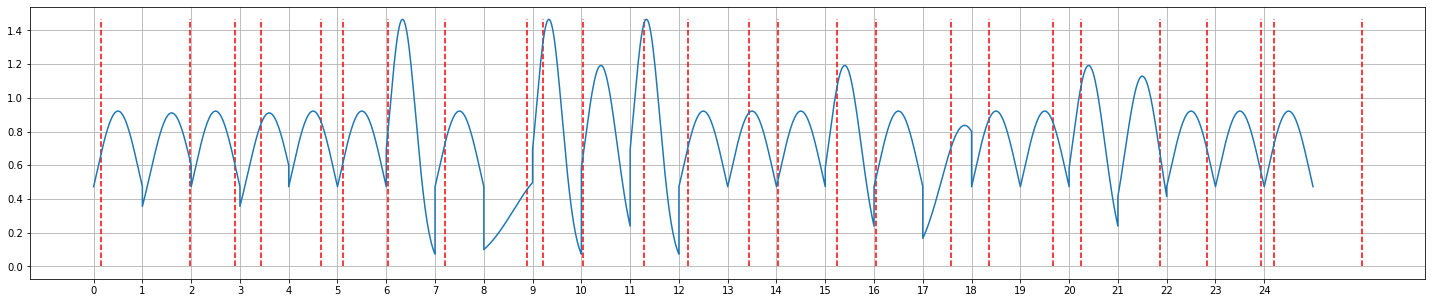

In [694]:
plot_posterior(means, stds, ground_truth=pref)

In [695]:
from math import pi
from scipy.stats import geom

In [696]:
n_samples = 100

In [697]:
expected_rewards, stds = params_to_gaussian(posterior)

In [698]:
expected_rewards

array([0.5       , 0.6       , 0.5       , 0.6       , 0.5       ,
       0.5       , 0.33333333, 0.5       , 1.33333333, 0.33333333,
       0.4       , 0.33333333, 0.5       , 0.5       , 0.5       ,
       0.4       , 0.5       , 0.85714286, 0.5       , 0.5       ,
       0.4       , 0.5       , 0.5       , 0.5       , 0.5       ])

In [699]:
stds

array([0.4330127 , 0.43817805, 0.4330127 , 0.43817805, 0.4330127 ,
       0.4330127 , 0.27216553, 0.4330127 , 0.7200823 , 0.27216553,
       0.33466401, 0.27216553, 0.4330127 , 0.4330127 , 0.4330127 ,
       0.33466401, 0.4330127 , 0.47687026, 0.4330127 , 0.4330127 ,
       0.33466401, 0.35355339, 0.4330127 , 0.4330127 , 0.4330127 ])

In [700]:
posterior;

In [701]:
a_star_t = np.sort(expected_rewards)[-K]
a_star_t

a_s = np.array([x[0] for x in posterior]).reshape(-1, 1)
b_s = np.array([x[1] for x in posterior]).reshape(-1, 1)

ps = beta.cdf(1 / (a_star_t + 1), a=a_s, b=b_s)
ps;

In [702]:
# top_k = K
# best_actions = np.sort(
#         np.argpartition(np.transpose(posterior_samples), -top_k, axis=1)[:, -top_k:], axis=1
#         )
# top_actions_dist = np.zeros(posterior_samples.shape)
# for sample_ix in range(n_samples):
#     top_actions_dist[best_actions[sample_ix], sample_ix] = 1.0
# ps = top_actions_dist.mean(1)
entropies_start = - (ps * np.log(np.maximum(ps,1e-12)) + (1 - ps) * np.log(np.maximum(1 - ps, + 1e-12)))
# posterior_samples[best_actions]

In [703]:
# ps = top_actions_dist.mean(1)
ps

array([[0.38146973],
       [0.47534704],
       [0.38146973],
       [0.47534704],
       [0.38146973],
       [0.38146973],
       [0.1937151 ],
       [0.38146973],
       [0.93146787],
       [0.1937151 ],
       [0.27418137],
       [0.1937151 ],
       [0.38146973],
       [0.38146973],
       [0.38146973],
       [0.27418137],
       [0.38146973],
       [0.72908051],
       [0.38146973],
       [0.38146973],
       [0.27418137],
       [0.36973506],
       [0.38146973],
       [0.38146973],
       [0.38146973]])

In [704]:
# entropies_start = - (ps * np.log(ps + 1e-12) + (1 - ps) * np.log(1 - ps + 1e-12))
entropies_start;

In [705]:
posterior_samples = 1 / beta.rvs(a=a_s, b=b_s) - 1
observations_samples = geom.rvs(1 / (posterior_samples + 1))#, size=(posterior_samples.shape[0],
#                                                                    posterior_samples.shape[1],
#                                                                    n_samples)) - 1
# entropies_start = 0.5 * np.log(2 * pi * np.exp(1) * stds ** 2)
# new_as = [[(posterior[i][0] + 1, posterior[i][1] + observations_samples[i][j]) for j in range(n_samples)] for i in range(N)]
# new_as = np.array([posterior[i][0] for i in range(N)]).reshape(-1, 1)
new_as = np.ones(observations_samples.shape)
new_bs = np.copy(observations_samples)
for i in range(N):
    new_bs[i] += posterior[i][1]
    new_as[i] += posterior[i][0]
# new_bs, new_as

In [706]:
ps = beta.cdf(1 / (a_star_t + 1), a=new_as, b=new_bs)

In [707]:
ps

array([[0.78338198],
       [0.54575503],
       [0.47534704],
       [0.69427188],
       [0.78338198],
       [0.47534704],
       [0.4467438 ],
       [0.47534704],
       [0.96256072],
       [0.28172508],
       [0.88223851],
       [0.28172508],
       [0.47534704],
       [0.47534704],
       [0.65136701],
       [0.36973506],
       [0.65136701],
       [0.75813951],
       [0.47534704],
       [0.47534704],
       [0.36973506],
       [0.72908051],
       [0.65136701],
       [0.47534704],
       [0.65136701]])

In [708]:
entropies_end =- (ps * np.log(np.maximum(ps,1e-12)) + (1 - ps) * np.log(np.maximum(1 - ps, + 1e-12)))

In [709]:
entropies_start

array([[0.66477905],
       [0.69193115],
       [0.66477905],
       [0.69193115],
       [0.66477905],
       [0.66477905],
       [0.49156527],
       [0.66477905],
       [0.24982538],
       [0.49156527],
       [0.58737351],
       [0.49156527],
       [0.66477905],
       [0.66477905],
       [0.66477905],
       [0.58737351],
       [0.66477905],
       [0.58417124],
       [0.66477905],
       [0.66477905],
       [0.58737351],
       [0.65881453],
       [0.66477905],
       [0.66477905],
       [0.66477905]])

In [710]:
entropies_end

array([[0.52259405],
       [0.68895427],
       [0.69193115],
       [0.61563989],
       [0.52259405],
       [0.69193115],
       [0.68746396],
       [0.69193115],
       [0.15971884],
       [0.59457522],
       [0.36244106],
       [0.59457522],
       [0.69193115],
       [0.69193115],
       [0.6465963 ],
       [0.65881453],
       [0.6465963 ],
       [0.55321501],
       [0.69193115],
       [0.69193115],
       [0.65881453],
       [0.58417124],
       [0.6465963 ],
       [0.69193115],
       [0.6465963 ]])

In [711]:
(entropies_start - entropies_end).max()

0.22493244917150873

In [712]:
# a_s = np.array([x[0] for x in posterior]).reshape(-1, 1)
# b_s = np.array([x[1] for x in posterior]).reshape(-1, 1)

# posterior_samples = 1 / beta.rvs(a=a_s, b=b_s, size=(a_s.shape[0], n_samples)) - 1

# observations_samples = geom.rvs(1 / (posterior_samples + 1)) - 1

# # new_as = np.ones((N, n_samples), dtype=int)

# new_posteriors = [[(posterior[i][0] + 1, posterior[i][1] + observations_samples[i][j]) for j in range(n_samples)] for i in range(N)]


# new_entropies = [
#     [0.5 * np.log(2 * pi * np.exp(1) * std ** 2) for std in params_to_gaussian(new_posteriors[i])[1]]
#     for i in range(N)
# ]

# new_entropies = np.array(new_entropies)

# new_entropies = new_entropies.mean(1)

reductions = (entropies_start - entropies_end)
reductions

array([[ 0.142185  ],
       [ 0.00297688],
       [-0.0271521 ],
       [ 0.07629126],
       [ 0.142185  ],
       [-0.0271521 ],
       [-0.19589869],
       [-0.0271521 ],
       [ 0.09010653],
       [-0.10300994],
       [ 0.22493245],
       [-0.10300994],
       [-0.0271521 ],
       [-0.0271521 ],
       [ 0.01818275],
       [-0.07144101],
       [ 0.01818275],
       [ 0.03095623],
       [-0.0271521 ],
       [-0.0271521 ],
       [-0.07144101],
       [ 0.07464328],
       [ 0.01818275],
       [-0.0271521 ],
       [ 0.01818275]])

In [713]:
expected_rewards

array([0.5       , 0.6       , 0.5       , 0.6       , 0.5       ,
       0.5       , 0.33333333, 0.5       , 1.33333333, 0.33333333,
       0.4       , 0.33333333, 0.5       , 0.5       , 0.5       ,
       0.4       , 0.5       , 0.85714286, 0.5       , 0.5       ,
       0.4       , 0.5       , 0.5       , 0.5       , 0.5       ])

In [714]:
from ts_agents import EpochSamplingTS
ts_cs_agent = EpochSamplingTS(k=K, n=N, horizon=10000, sampling=1, limited_prefs=False)
ts_cs_agent.posterior_parameters = posterior

Agent believes first=best? False


In [715]:
ts_cs_action = ts_cs_agent.proposal()
ts_cs_action

array([ 1,  8, 17])

In [716]:
from ids_utils import info_gain_step, numba_expected_reward
from env import act_optimally

In [717]:
posterior_samples = np.transpose(posterior_samples)

In [718]:
# sorted_beliefs = np.sort(posterior_samples, axis=1)[
#     :, -K :
# ]  # shape (m, k)
# picking_probabilities = sorted_beliefs.sum(1)
# r_star = picking_probabilities.mean()
# a_greedy = act_optimally(
#     posterior_samples.mean(0), K
# )
# greedy_expected_reward = numba_expected_reward(
#     posterior_samples, a_greedy, mode="step"
# )
# delta_min = r_star - greedy_expected_reward
# assert delta_min > -1e-12
# delta_min = max(1e-12, delta_min)

# posteriors_actions = act_optimally(
#     posterior_samples, K
# )
# posteriors_actions = [
#     tuple(posteriors_actions[ix, :]) for ix in range(n_samples)
# ]
# optimal_actions_information = defaultdict(list)
# for ix, action in enumerate(posteriors_actions):
#     optimal_actions_information[action].append(ix)

# optimal_actions = {
#     action: (len(theta_idxs) / n_samples, theta_idxs)
#     for action, theta_idxs in optimal_actions_information.items()
# }
# actions_star = np.array(
#     [list(key) for key in optimal_actions_information.keys()]
# )
# counts_star = np.array(
#     [len(val) for val in optimal_actions_information.values()]
# )
# thetas_star = []
# for val in optimal_actions_information.values():
#     thetas_star += val
# thetas_star = np.array(thetas_star)
# gain_ts_cs = info_gain_step(action=ts_cs_action,
#                             sampled_preferences=posterior_samples,
#                             actions_star=actions_star,
#                             counts=counts_star,
#                             thetas=thetas_star)

In [719]:
ts_cs_gain = reductions[ts_cs_action].sum()

In [720]:
ts_cs_gain

0.12403964464755876

In [721]:
expected_rewards

array([0.5       , 0.6       , 0.5       , 0.6       , 0.5       ,
       0.5       , 0.33333333, 0.5       , 1.33333333, 0.33333333,
       0.4       , 0.33333333, 0.5       , 0.5       , 0.5       ,
       0.4       , 0.5       , 0.85714286, 0.5       , 0.5       ,
       0.4       , 0.5       , 0.5       , 0.5       , 0.5       ])

In [722]:
x = cp.Variable(N)

objective = cp.Maximize(expected_rewards @ x )
constraints = [0 <= x, x <= 1, cp.sum(x) == K, x @ reductions >= ts_cs_gain]
prob = cp.Problem(objective, constraints,
                 )
prob.solve(solver='ECOS')

2.790476190396185

In [723]:
x.value

array([7.67715748e-11, 4.85194769e-01, 2.03528876e-11, 5.14805230e-01,
       7.67715748e-11, 2.03528876e-11, 6.90304193e-12, 2.03528876e-11,
       1.00000000e+00, 1.01496763e-11, 4.72642872e-11, 1.01496763e-11,
       2.03528876e-11, 2.03528876e-11, 3.19545668e-11, 1.54044312e-11,
       3.19545668e-11, 1.00000000e+00, 2.03528876e-11, 2.03528876e-11,
       1.54044312e-11, 4.88529626e-11, 3.19545668e-11, 2.03528876e-11,
       3.19545668e-11])

In [724]:
act_optimally(
            np.squeeze(x.value), top_k=K
        )

array([ 3,  8, 17])